In [1]:
# %set_env CUDA_VISIBLE_DEVICES=7
# %load_ext cudf.pandas
import pandas as pd

# from eval_vlm.datasets_zoo.registry import list_datasets
from unibench.models_zoo.registry import list_models
from unibench.benchmarks_zoo import list_benchmarks
from unibench.output import OutputHandler
import seaborn as sns
import matplotlib.pyplot as plt

models = list_models("all")
datasets = list_benchmarks("all")
outputhandler = OutputHandler(output_dir="/fsx-robust/haideraltahan/outputs")
print(pd)

/data/home/haideraltahan/anaconda3/envs/clip/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'pandas' from '/data/home/haideraltahan/anaconda3/envs/clip/lib/python3.11/site-packages/pandas/__init__.py'>


In [21]:
outputhandler.load_all_csv(
    model_name=models,
    benchmark_name=datasets,
)

File not found:  /fsx-robust/haideraltahan/outputs/blip2_7b/caltech101.f
File not found:  /fsx-robust/haideraltahan/outputs/blip2_7b/cars.f
File not found:  /fsx-robust/haideraltahan/outputs/blip2_7b/cifar10.f
File not found:  /fsx-robust/haideraltahan/outputs/blip2_7b/cifar100.f
File not found:  /fsx-robust/haideraltahan/outputs/blip2_7b/clevr_count.f
File not found:  /fsx-robust/haideraltahan/outputs/blip2_7b/clevr_distance.f
File not found:  /fsx-robust/haideraltahan/outputs/blip2_7b/coco_order.f
File not found:  /fsx-robust/haideraltahan/outputs/blip2_7b/countbench.f
File not found:  /fsx-robust/haideraltahan/outputs/blip2_7b/country211.f
File not found:  /fsx-robust/haideraltahan/outputs/blip2_7b/cub.f
File not found:  /fsx-robust/haideraltahan/outputs/blip2_7b/dmlab.f
File not found:  /fsx-robust/haideraltahan/outputs/blip2_7b/dollar_street.f
File not found:  /fsx-robust/haideraltahan/outputs/blip2_7b/dspr_orientation.f
File not found:  /fsx-robust/haideraltahan/outputs/blip2_7b/

In [50]:
results = outputhandler.query(
    outputhandler._aggregate, **{"benchmark_name": datasets, "model_name": models}
)

In [56]:
df_mean = (
    results.groupby(["model_name", "benchmark_name"]).correctness.mean().reset_index()
)
df_sem = (
    results.groupby(["model_name", "benchmark_name"]).correctness.sem().reset_index()
)
baseline = df_mean[df_mean.model_name == "clip_vitB32"]
baseline.sort_values(by=["model_name", "benchmark_name"], ascending=False, inplace=True)
df_mean.sort_values(by=["model_name", "benchmark_name"], ascending=False, inplace=True)

/tmp/ipykernel_3837666/2130700335.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline.sort_values(by=["model_name", "benchmark_name"], ascending=False, inplace=True)


In [57]:
df_adj = df_mean.copy()
for model in df_mean.model_name.unique():
    if model == "clip_vitB32":
        continue
    df_adj.loc[df_adj.model_name == model, "correctness"] = (
        df_mean[df_mean.model_name == model].correctness.values
        * baseline.correctness.values
    )

/tmp/ipykernel_3837666/4198293138.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(


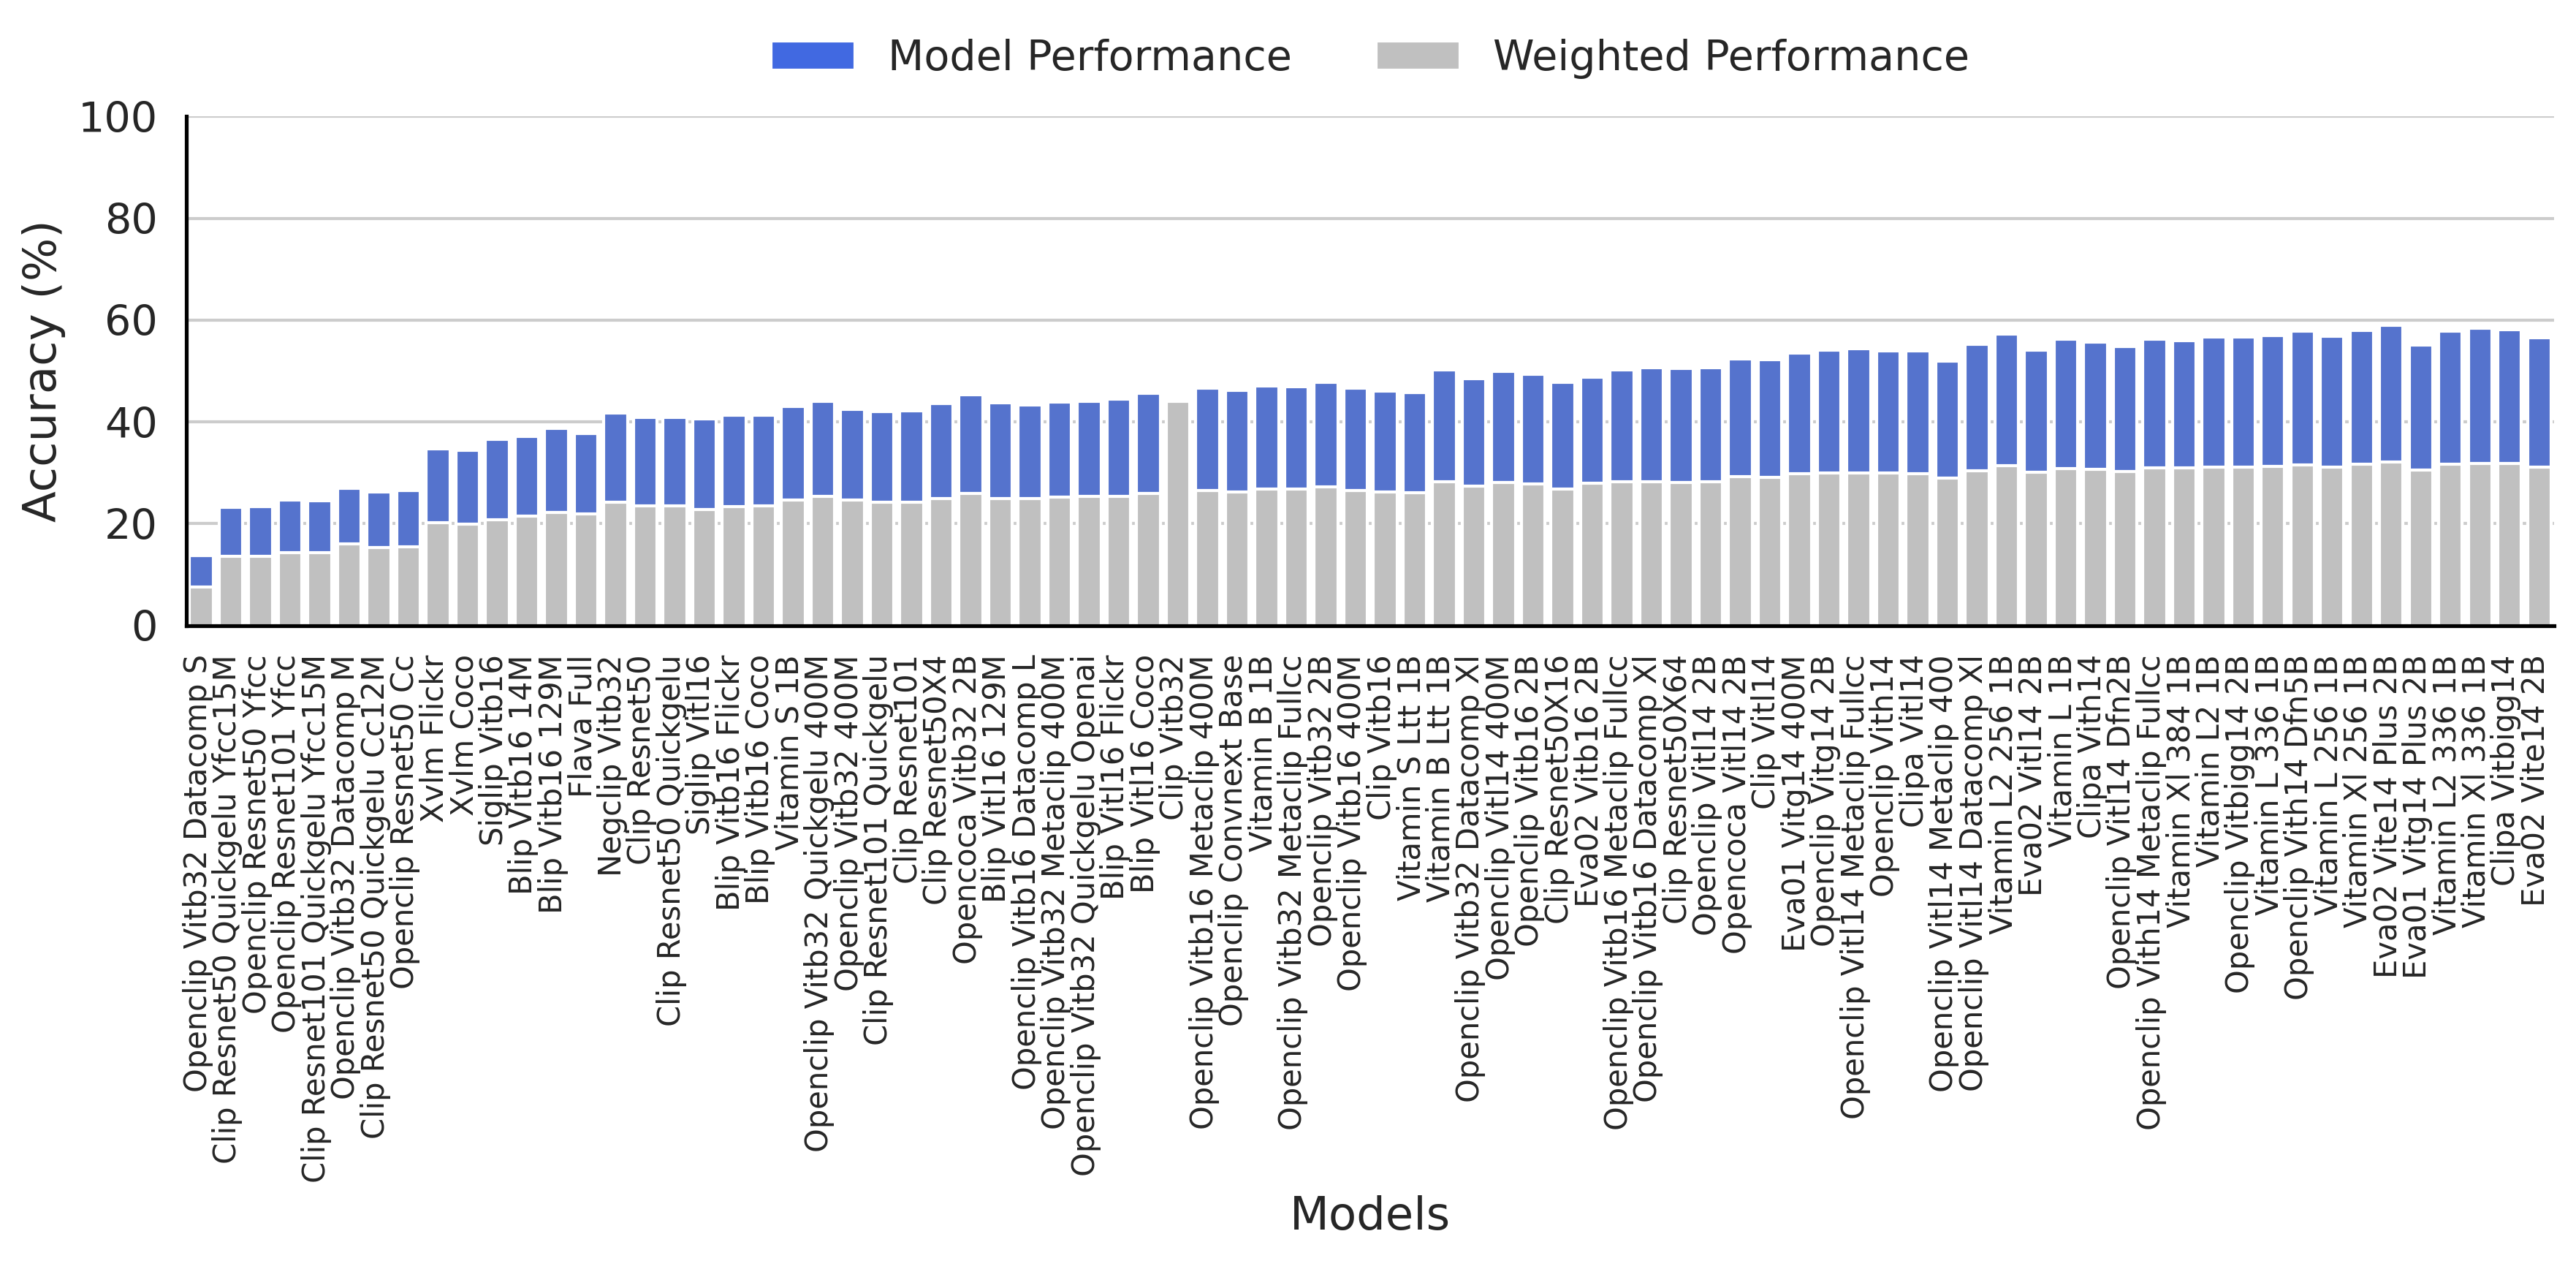

In [58]:
sns.set(font_scale=1.25)
sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12, 6), dpi=300)


order = list(
    (
        df_mean.reset_index()
        .groupby("model_name")
        .correctness.median()
        .sort_values()
        .index
    )
)
# order.append("2 Layer MLP")

m = df_mean.reset_index().groupby("model_name").correctness.mean() * 100
s = df_sem.reset_index().groupby("model_name").correctness.mean() * 100

adj = df_adj.reset_index().groupby("model_name").correctness.mean() * 100
# m["2 Layer MLP"] = 98.26
# s["2layer"] = 0

sns.set_style(
    "whitegrid",
    rc={"ytick.left": True, "axes.grid": True},
)


ax1 = sns.barplot(
    x=list(m.keys()),
    y=list(m.values),
    palette=[
        "royalblue" if "2 Layer MLP" not in x else "forestgreen" for x in list(m.keys())
    ],
    errorbar=None,
    order=order,
    ax=axs,
)


axs = sns.barplot(
    x=list(adj.keys()),
    y=list(adj.values),
    errorbar=None,
    order=order,
    ax=axs,
    color="silver",
)


for _, s in ax1.spines.items():
    s.set_color("black")

axs.set_ylim(0, 100)
sns.despine(ax=axs)

from matplotlib.patches import Patch

lgd = plt.legend(
    title=None,
    ncol=3,
    loc="lower center",
    bbox_to_anchor=(0.5, 1),
    handles=[
        Patch(
            facecolor="royalblue",
            label="Model Performance",
        ),
        Patch(
            facecolor="silver",
            label="Weighted Performance",
        ),
    ],
    frameon=False,
)

# axs.axhline(y=10, linestyle="--", color="silver")
# axs.text(63, 10, 'Chance', fontsize=10, va='center', ha='center', backgroundcolor='w')
axs.set_xticks(
    [x + 0.4 for x in axs.get_xticks()],
    [x.replace("_", " ").title() for x in order],
    rotation=90,
    ha="right",
)
axs.tick_params(axis="x", which="major", labelsize=10)

axs.set_xlabel("Models")
axs.set_ylabel("Accuracy (%)")
plt.tight_layout()
plt.savefig("results_weighted.pdf", dpi=300, bbox_inches="tight")